## Classifying Customer Churn with Gradient Boosting
by Eli Taylor
### Import libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

### Import data

In [2]:
# I have already cleaned this dataset, converted values to numeric where needed, and created dummy variables
data_for_modeling = pd.read_csv('Cleaned_data.csv', index_col=0)

### Evaluate data

In [3]:
# view data
data_for_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  int64  
 10  Geography_Spain    10000 non-null  int64  
 11  Gender_Male        10000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 1015.6 KB


In [4]:
data_for_modeling.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [5]:
data_for_modeling.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Prepare data for modeling
Sklearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html \
SOURCE - Machine Learning Mastery: https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/ \
Reference for ROC curve: https://www.statology.org/plot-multiple-roc-curves-python/

In [51]:
# target variable is "Exited" aka whether customer was retained or left
X = data_for_modeling.drop(columns=['Exited'])
y = data_for_modeling['Exited']

In [52]:
# split into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
    )

### Create Model

In [78]:
# function to create model where parameters can be specified to make it easier to tune later
def model_creation(n_est=100,lr=1.0, max_depth=1):
    # define the model
    model = GradientBoostingClassifier(n_estimators=n_est, learning_rate=lr, max_depth=max_depth, random_state=42)
    # fit the model on the dataset
    model.fit(X_train, y_train)
    return model

# initial model
model_1 = model_creation()

In [79]:
# get predictions
yhat = model_1.predict(X_test)
print(f'Predictions: {yhat}')
# get a single prediction
print(f'A Single Predicted Class: {yhat[0]}')

Predictions: [0 0 0 ... 0 0 0]
A Single Predicted Class: 0


### Model Evaluation

In [67]:
# function prints a collection of model evaluation metrics
def evaluate_model(model):
    score = model.score(X_test, y_test)
    # score returns the mean accuracy on the given test data and labels.
    print(f'Model score: {round(score, 4)}')

    # define the evaluation method
    cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    # evaluate the model on the dataset
    n_scores = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cross_validation, n_jobs=-1)
    # report performance
    print(f'Mean Accuracy using Cross-Validation: {round(np.mean(n_scores), 4)}')
    print(f'Standard Deviation using Cross-Validation: {round(np.std(n_scores), 4)}')

def plot_the_roc(model):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
    display.plot()
    plt.title('ROC Curve')
    plt.show()

Model score: 0.8637


Mean Accuracy using Cross-Validation: 0.8597
Standard Deviation using Cross-Validation: 0.0202


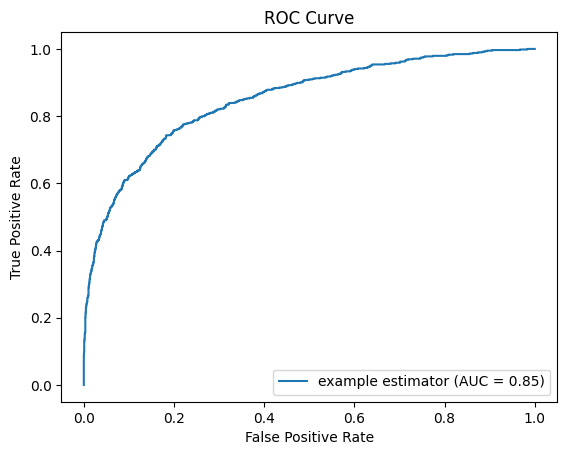

In [80]:
evaluate_model(model_1)
plot_the_roc(model_1)

### Hyperparameter Tuning
Info on gradient boosting parameters: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

In [81]:
# initial values: n_estimators=100, learning_rate=1.0, max_depth=1

n_estimators = [32, 64, 100, 200]

# review model scores for different number of estimators
for est in n_estimators:
    print(f'Model results for n_estimators = {est}')
    model = model_creation(n_est=est)
    evaluate_model(model)
    print("")

Model results for n_estimators = 32


Model score: 0.8647
Mean Accuracy using Cross-Validation: 0.8617
Standard Deviation using Cross-Validation: 0.0189

Model results for n_estimators = 64
Model score: 0.8603
Mean Accuracy using Cross-Validation: 0.8608
Standard Deviation using Cross-Validation: 0.02

Model results for n_estimators = 100
Model score: 0.8637
Mean Accuracy using Cross-Validation: 0.8597
Standard Deviation using Cross-Validation: 0.0202

Model results for n_estimators = 200
Model score: 0.864
Mean Accuracy using Cross-Validation: 0.8578
Standard Deviation using Cross-Validation: 0.0178



In [73]:
max_depth = [1, 4, 8, 16]

# review model scores for different values of max_depth
for dep in max_depth:
    print(f'Model results for max_depth = {dep}')
    model = model_creation(max_depth = dep)
    evaluate_model(model)
    print("")

Model results for max_depth = 1
Model score: 0.8637
Mean Accuracy using Cross-Validation: 0.8597
Standard Deviation using Cross-Validation: 0.0202

Model results for max_depth = 4
Model score: 0.8273
Mean Accuracy using Cross-Validation: 0.829
Standard Deviation using Cross-Validation: 0.0185

Model results for max_depth = 8
Model score: 0.842
Mean Accuracy using Cross-Validation: 0.8466
Standard Deviation using Cross-Validation: 0.0174

Model results for max_depth = 16
Model score: 0.852
Mean Accuracy using Cross-Validation: 0.8204
Standard Deviation using Cross-Validation: 0.0227



In [74]:
learning_rate = [1.0, 0.5, 0.25, 0.1]

# review model scores for different values of max_depth
for rate in learning_rate:
    print(f'Model results for max_depth = {rate}')
    model = model_creation(lr = rate)
    evaluate_model(model)
    print("")

Model results for max_depth = 1.0
Model score: 0.8637
Mean Accuracy using Cross-Validation: 0.8597
Standard Deviation using Cross-Validation: 0.0202

Model results for max_depth = 0.5
Model score: 0.8633
Mean Accuracy using Cross-Validation: 0.8603
Standard Deviation using Cross-Validation: 0.0178

Model results for max_depth = 0.25
Model score: 0.8637
Mean Accuracy using Cross-Validation: 0.8629
Standard Deviation using Cross-Validation: 0.0175

Model results for max_depth = 0.1
Model score: 0.8613
Mean Accuracy using Cross-Validation: 0.8603
Standard Deviation using Cross-Validation: 0.0157



In [75]:
model_2 = model_creation(32, 0.1, 1)

Model score: 0.8267
Mean Accuracy using Cross-Validation: 0.8233
Standard Deviation using Cross-Validation: 0.0089


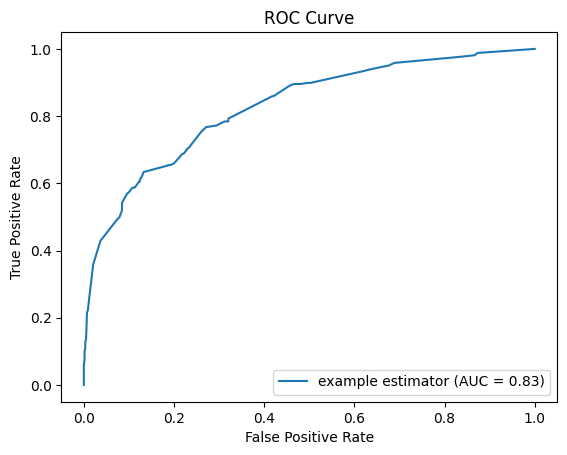

In [76]:
evaluate_model(model_2)
plot_the_roc(model_2)

Model score: 0.8627
Mean Accuracy using Cross-Validation: 0.8529
Standard Deviation using Cross-Validation: 0.0154


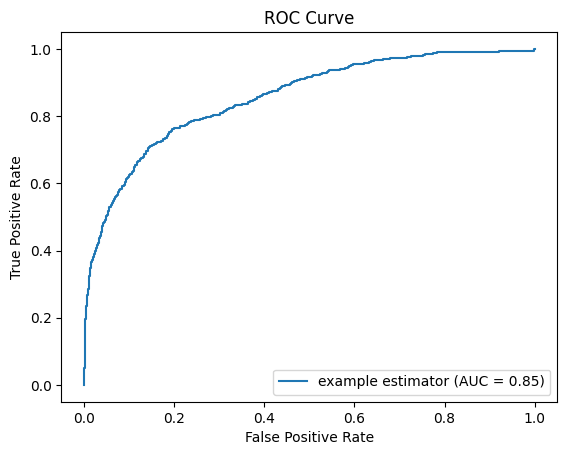

In [77]:
model_3 = model_creation(32, 0.1, 8)
evaluate_model(model_3)
plot_the_roc(model_3)

Model score: 0.8633
Mean Accuracy using Cross-Validation: 0.853
Standard Deviation using Cross-Validation: 0.0157


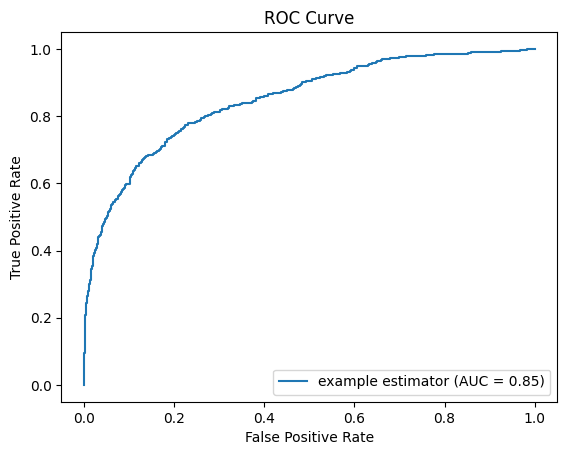

In [82]:
model_4 = model_creation(100, 0.1, 8)
evaluate_model(model_4)
plot_the_roc(model_4)

In [88]:
print('Compare best models:', '\n')

print('Model_1 Results')
evaluate_model(model_1)
print('')
print('Model_4 results:')
evaluate_model(model_4)

Compare best models: 

Model_1 Results
Model score: 0.8637
Mean Accuracy using Cross-Validation: 0.8597
Standard Deviation using Cross-Validation: 0.0202

Model_4 results:
Model score: 0.8633
Mean Accuracy using Cross-Validation: 0.853
Standard Deviation using Cross-Validation: 0.0157


### Results
After hyperparameter tuning, it seems the best AUC is 0.85 and the model accuracy is averaging 85-86% on the validation data. Model_1 appears to have slightly better performance over other parameter combinations.